In [9]:
import torch
from torch.nn.functional import relu
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [6]:
aug = MNISTAug()
dm = DataManager()
dm.load_test()

In [7]:
x, y = aug.get_augmented(dm.x_test, dm.y_test, 10)

In [21]:
x = torch.tensor(x.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

<ipython-input-21-5f8ba7c27508>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')


[{'class': 8,
  'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  'x1': 51,
  'y1': 90,
  'x2': 66,
  'y2': 105,
  'cx': 58.5,
  'cy': 97.5,
  'height': 15,
  'width': 15}]

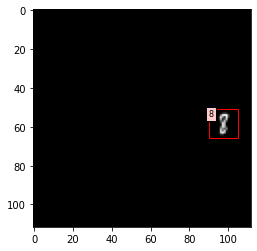

In [41]:
DataManager.plot_num(x[1].reshape((112, 112)), y[1])
y[1]

In [36]:

class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.linear2 = torch.nn.Linear(4096, 512)
        self.linear3 = torch.nn.Linear(512, 4)

    def forward(self, x):
        print(x.shape)
        x = relu(self.conv1(x))  # 112
        print(x.shape)
        x = relu(self.conv2(x))  # 56
        print(x.shape)
        x = relu(self.conv3(x))  # 28
        print(x.shape)
        x = relu(self.conv4(x))  # 14
        print(x.shape)
        x = relu(self.conv5(x))  # 7
        print(x.shape)
        x = torch.flatten(x, 1)
        print(x.shape)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = self.linear3(x)
        return x


model = DetectorV1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
optimizer.zero_grad()

y_hat = model(x)

torch.Size([10, 1, 112, 112])
torch.Size([10, 32, 112, 112])
torch.Size([10, 64, 56, 56])
torch.Size([10, 128, 28, 28])
torch.Size([10, 256, 14, 14])
torch.Size([10, 512, 7, 7])
torch.Size([10, 25088])


In [38]:
cx_d_hat, cy_d_hat, h_d_hat, w_d_hat = y_hat[0]

tensor([[0.0427, 0.0184, 0.0258, 0.0385],
        [0.0427, 0.0185, 0.0259, 0.0384],
        [0.0426, 0.0184, 0.0258, 0.0384],
        [0.0428, 0.0185, 0.0259, 0.0385],
        [0.0426, 0.0185, 0.0258, 0.0384],
        [0.0426, 0.0185, 0.0256, 0.0385],
        [0.0427, 0.0185, 0.0258, 0.0384],
        [0.0427, 0.0185, 0.0258, 0.0384],
        [0.0427, 0.0185, 0.0259, 0.0384],
        [0.0427, 0.0185, 0.0260, 0.0383]], grad_fn=<AddmmBackward>)

In [61]:
anchor_cx = 56
anchor_cy = 56
anchor_h = 28
anchor_w = 28

In [62]:
print(y[0][0])
cx_d = (y[0][0]['cx'] - anchor_cx) / 112
cy_d = (y[0][0]['cy'] - anchor_cy) / 112
w_d = (y[0][0]['width'] - anchor_w) / 112
h_d = (y[0][0]['height'] - anchor_h) / 112

{'class': 3, 'class_one_hot': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'x1': 67, 'y1': 76, 'x2': 91, 'y2': 100, 'cx': 79.0, 'cy': 88.0, 'height': 24, 'width': 24}


In [66]:
yi = torch.tensor((cx_d, cy_d, w_d, h_d))
yi

tensor([ 0.2054,  0.2857, -0.0357, -0.0357])

In [ ]:
loss_i = yi - y_hat[0]
loss_i

tensor([ 0.2075,  0.2719, -0.0368, -0.0460], grad_fn=<SubBackward0>)